In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

from tslearn.clustering import silhouette_score

In [ ]:
def process_lit(path, year):
    lit=pd.read_excel(path).replace("-", 0).fillna(0)
    lit = lit.pivot(index="Semaine", columns="Code UF", values="Lits fermés moyens")
    lit['date_semaine'] = pd.date_range(start=f'{year}-01-01', periods=52, freq='W')
    lit.set_index('date_semaine', inplace=True)
    lit=lit.clip(lower=0)
    return lit

In [ ]:
lit_24= process_lit(r"C:\Stage\generated_data\lits\lit_2024.xlsx", 2024)
lit_23= process_lit(r"C:\Stage\generated_data\lits\lit_2023.xlsx", 2023)
lit= pd.concat([lit_23, lit_24], axis=0).fillna(0)




In [ ]:
zero_only_columns = (lit == 0).all()
zero_column_names = zero_only_columns[zero_only_columns].index.tolist()
lit=lit.drop(columns=zero_column_names)

X_train = lit.T.values[:, :,np.newaxis]

In [ ]:
score=[]
inertia=[]
n_clusters = list(range(2,6))
for i in  n_clusters:
    km = TimeSeriesKMeans(n_clusters=i, metric='euclidean',random_state=0, dtw_inertia=True)
    y_pred = km.fit_predict(X_train)
    inertia.append(km.inertia_)
    score.append(silhouette_score(X_train, y_pred, metric='dtw'))
    print(i)


fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Silhouette score plot
axes[0].plot(n_clusters, score, marker='o')
axes[0].set_xlabel("Number of clusters")
axes[0].set_ylabel("Silhouette score")
axes[0].set_title("Silhouette Score vs Number of Clusters")

# DTW inertia plot
axes[1].plot(n_clusters, inertia, marker='o', color='red')
axes[1].set_xlabel("Number of clusters")
axes[1].set_ylabel("DTW Inertia")
axes[1].set_title("DTW Inertia vs Number of Clusters")

plt.tight_layout()
plt.show()

In [39]:
km = TimeSeriesKMeans(n_clusters=2, metric="euclidean",dtw_inertia=True, random_state=0)
y_pred = km.fit_predict(X_train)
print(km.inertia_)
silhouette_score(X_train, y_pred, metric='dtw')

c:\Users\yessi\anaconda3\envs\new_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\yessi\anaconda3\envs\new_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


440.90209432928157


0.6348704924081702

In [40]:
y_pred=y_pred.reshape(1,-1)
clusters = pd.DataFrame(y_pred, columns=lit.columns)
c1= clusters.loc[0] ==1
c0 = clusters.loc[0] == 0
lit_cluster_0 = lit[lit.columns[c0].tolist()]
lit_cluster_1 = lit[lit.columns[c1].tolist()]

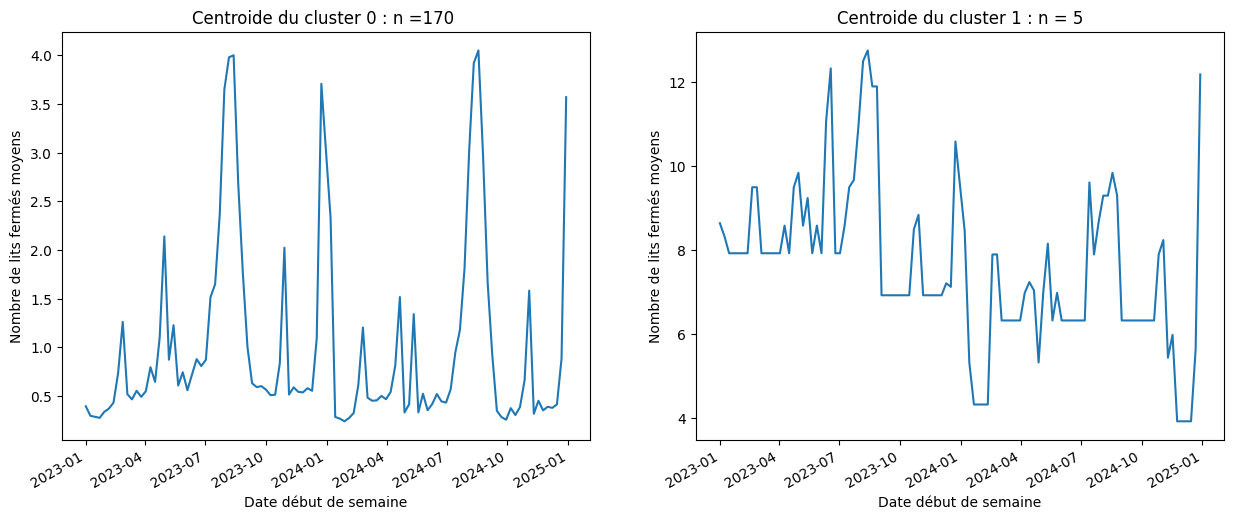

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))


pd.DataFrame(km.cluster_centers_[0], index=lit.index).plot(ax=axes[0], legend=False)
axes[0].set_title(f"Centroide du cluster 0 : n ={len(lit_cluster_0.columns)} ")
axes[0].set_ylabel("Nombre de lits fermés moyens")
axes[0].set_xlabel("Date début de semaine")

pd.DataFrame(km.cluster_centers_[1], index=lit.index).plot(ax=axes[1], legend=False)
axes[1].set_title(f"Centroide du cluster 1 : n = {len(lit_cluster_1.columns)}")
axes[1].set_ylabel("Nombre de lits fermés moyens")
axes[1].set_xlabel("Date début de semaine")


plt.show()


In [43]:
correlation_matrix = lit_cluster_0.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
upper_triangle = correlation_matrix.where(mask)
total_pairs = upper_triangle.count().sum()
high_corr_pairs = (abs(upper_triangle) >= 0.75).sum().sum()
percentage = (high_corr_pairs / total_pairs) * 100
print(f"\nTotal unique pairs: {total_pairs}")
print(f"Pairs with correlation > 0.75: {high_corr_pairs}")
print(f"Percentage of pairs with correlation > 0.75: {percentage:.2f}%")


Total unique pairs: 14365
Pairs with correlation > 0.75: 274
Percentage of pairs with correlation > 0.75: 1.91%


In [44]:
lit_cluster_0.to_csv("lit_cluster_0.csv")
lit_cluster_1.to_csv("lit_cluster_1.csv")